In [1]:
# pip install pyarrow
# pip install opencv-python==4.11.0.86
# pip install moviepy==1.0.3

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import re
import json
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import get_session_name_from_path, plot_keypoint_confidence_analysis


# helper functions

In [3]:
def get_trial_level_df(nwb_df_licks, tongue_movs, nwb_df_trials):
    # Aggregate licks per trial
    licks_per_trial = nwb_df_licks.groupby('trial').size().rename('lick_count')
    # Aggregate coverage per trial: percent of licks with a movement
    covered = nwb_df_licks['nearest_movement_id'].notna().groupby(nwb_df_licks['trial']).mean().rename('coverage_pct')
    # Lick count in first 10s of each trial
    first_licks = []
    for trial, row in nwb_df_trials.set_index('trial').iterrows():
        start = row['goCue_start_time_in_session']
        end = start + 10
        licks_in_window = nwb_df_licks[
            (nwb_df_licks['trial'] == trial) &
            (nwb_df_licks['timestamps'] >= start) &
            (nwb_df_licks['timestamps'] < end)
        ]
        first_licks.append(len(licks_in_window))
    first10s_lick_count = pd.Series(first_licks, index=nwb_df_trials['trial'], name='first10s_lick_count')
    # Merge with trial info
    trial_df = nwb_df_trials.set_index('trial').join([licks_per_trial, covered, first10s_lick_count])
    trial_df['lick_count'] = trial_df['lick_count'].fillna(0).astype(int)
    trial_df['coverage_pct'] = trial_df['coverage_pct'] * 100
    trial_df['first10s_lick_count'] = trial_df['first10s_lick_count'].fillna(0).astype(int)
    return trial_df

In [4]:

def generate_tongue_dfs(predictions_csv_path: Path, data_root: Path, tolerance=0.01):
    """
    Runs the full pipeline for one session and returns the NWB object, 
    annotated tongue kinematics, and aggregated tongue movements.

    Parameters
    ----------
    predictions_csv_path : Path
        Path to the predictions CSV (LP_csv).
    data_root : Path
        Root folder containing behavior_<…> session subfolders.
    tolerance : float, optional
        Lick-kinematics matching tolerance (default 0.01).

    Returns
    -------
    tuple : (nwb, tongue_kin, tongue_movs)
        nwb: NWBFile object with annotated licks/trials added
        tongue_kin: frame-level annotated tongue kinematics (DataFrame)
        tongue_movs: movement-level aggregated tongue movements (DataFrame)
    """
    # === Imports inside so function is self-contained ===
    from aind_dynamic_foraging_behavior_video_analysis.kinematics.kinematics_nwb_utils import get_nwb_file
    from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
        load_keypoints_from_csv, find_behavior_videos_folder,
        integrate_keypoints_with_video_time, mask_keypoint_data,
        kinematics_filter, segment_movements_trimnans,
        annotate_trials_in_kinematics, annotate_licks_in_kinematics,
        assign_movements_to_licks, aggregate_tongue_movements,
        add_lick_metadata_to_movements, get_session_name_from_path
    )
    import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
    from aind_dynamic_foraging_basic_analysis.licks import annotation

    # === 1) Session detection ===
    lp_csv = predictions_csv_path
    session_id = get_session_name_from_path(str(lp_csv))
    print(f"\n=== Generating tongue data for session: {session_id} ===")
    print(f"Predictions CSV: {lp_csv}")

    # === 2) Load keypoints ===
    kps = load_keypoints_from_csv(str(lp_csv))
    print(f"Loaded keypoints: {len(kps)} raw dataframes")

    # === 3) Locate synced video CSV ===
    videos_folder = find_behavior_videos_folder(str(data_root / session_id))
    if videos_folder is None:
        raise FileNotFoundError(f"Videos folder not found for session {session_id}")
    video_csv = Path(videos_folder) / "bottom_camera.csv"
    if not video_csv.exists():
        raise FileNotFoundError(f"Expected video CSV at {video_csv}")
    print(f"Found video CSV: {video_csv}")

    # === 4) Sync keypoints to video time ===
    kps_trim, _ = integrate_keypoints_with_video_time(str(video_csv), kps)
    print(f"Synced keypoints")

    # === 5) Tongue movement segmentation ===
    tongue_masked = mask_keypoint_data(kps_trim, 'tongue_tip_center', confidence_threshold=0.90)
    tongue_filtered = kinematics_filter(tongue_masked, cutoff_freq=50, filter_order=4, filter_kind='cubic')
    tongue_seg = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)
    print(f"Segmented {tongue_seg['movement_id'].nunique()} unique movements")

    # === 6) Load NWB and annotate ===
    nwb = get_nwb_file(session_id)
    nwb.df_events = nwb_utils.create_events_df(nwb)
    nwb.df_trials = nwb_utils.create_df_trials(nwb)
    nwb.df_licks = annotation.annotate_licks(nwb)
    print(f"NWB load: {len(nwb.df_trials)} trials, {len(nwb.df_licks)} licks")

    tongue_annot = annotate_trials_in_kinematics(tongue_seg, nwb.df_trials)
    tongue_kin = annotate_licks_in_kinematics(tongue_annot, nwb.df_licks, tolerance=tolerance)
    nwb.df_licks = assign_movements_to_licks(tongue_kin, nwb.df_licks)
    print("Annotated kinematics with trials & licks")

    # === 7) Aggregate movements ===
    tongue_movs = aggregate_tongue_movements(tongue_kin, kps_trim)
    tongue_movs = add_lick_metadata_to_movements(
        tongue_movs, nwb.df_licks, fields=['cue_response','rewarded','event']
    )
    print(f"Aggregated movements DF shape: {tongue_movs.shape}")

    # === 8) Trial-level DF ===
    tongue_trials = get_trial_level_df(nwb.df_licks, tongue_movs, nwb.df_trials)
    print(f"Aggregated trial-level DF shape: {tongue_trials.shape}")

    return nwb, tongue_kin, tongue_movs, kps_trim, tongue_trials


In [5]:
def select_percentile_movements(
    df: pd.DataFrame,
    metric_col: str,
    percentiles: list = [0, 0.25, 0.5, 0.75, 1.0]
) -> pd.DataFrame:
    """
    Return movement_ids and corresponding metric values at specified percentiles.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'movement_id' and the metric column.
    metric_col : str
        Name of the numeric column to sort and index into.
    percentiles : list of float
        Values between 0 and 1 for desired percentiles.

    Returns
    -------
    pd.DataFrame
        Columns: ['movement_id', metric_col, 'percentile']
    """
    if metric_col not in df.columns:
        raise ValueError(f"Column '{metric_col}' not found")
    series = df[['movement_id', metric_col]].dropna()
    if not pd.api.types.is_numeric_dtype(series[metric_col]):
        raise ValueError(f"Column '{metric_col}' must be numeric")
    if any(p < 0 or p > 1 for p in percentiles):
        raise ValueError("Percentiles must be in [0, 1]")

    sorted_df = series.sort_values(metric_col).reset_index(drop=True)
    N = len(sorted_df)
    if N == 0:
        return pd.DataFrame(columns=['movement_id', metric_col, 'percentile'])

    rows = []
    for p in percentiles:
        idx = int(round(p * (N - 1)))
        rows.append({
            'movement_id': int(sorted_df.loc[idx, 'movement_id']),
            metric_col: sorted_df.loc[idx, metric_col],
            'percentile': p
        })

    return pd.DataFrame(rows)

def plot_movement_tiles_scatter(
    tongue_segmented: pd.DataFrame,
    movement_ids: list,
    x_col: str,
    y_col: str,
    labels: list = None,
    color: str = 'gray',
    s: int = 5,
    title: str = None,
    return_fig=False
):
    """
    Plot scatter of any two kinematic columns for a given list of movement_ids.

    Parameters
    ----------
    tongue_segmented : pd.DataFrame
        Frame-level data with at least 'movement_id', x_col, y_col.
    movement_ids : list
        Movement IDs to plot (one subplot per movement).
    x_col : str
        Column in tongue_segmented to plot on x-axis.
    y_col : str
        Column in tongue_segmented to plot on y-axis.
    labels : list, optional
        List of strings or values to annotate each subplot (same length as movement_ids).
    color : str
        Point color for scatter.
    s : int
        Point size for scatter.
    title : str
        Title of figure
    """
    n = len(movement_ids)
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2), sharex=True, sharey=True)
    if n == 1:
        axes = [axes]

    # Global axis limits
    all_x, all_y = [], []
    for mid in movement_ids:
        df = tongue_segmented[tongue_segmented['movement_id'] == mid]
        df = df[[x_col, y_col]].dropna()
        all_x.extend(df[x_col])
        all_y.extend(df[y_col])
    if not all_x:
        raise RuntimeError("No valid movements found to plot.")
    xlim = (min(all_x), max(all_x))
    ylim = (min(all_y), max(all_y))

    for i, (ax, mid) in enumerate(zip(axes, movement_ids)):
        df = tongue_segmented[tongue_segmented['movement_id'] == mid]
        df = df[[x_col, y_col]].dropna()

        if len(df) < 1:
            ax.scatter([0], [0], s=10, color='black')
        else:
            ax.scatter(df[x_col], df[y_col], s=s, color=color)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel(x_col, fontsize=7)
        if ax == axes[0]:
            ax.set_ylabel(y_col, fontsize=7)

        if labels is not None:
            ax.set_title(str(labels[i]), fontsize=8)
    
    if title:
        plt.suptitle(title, fontsize=10)
    else:
        plt.suptitle(f"{y_col} vs {x_col}", fontsize=10)
    
    # plt.suptitle(f"{y_col} vs {x_col}", fontsize=10)
    plt.tight_layout()
    if return_fig:
        return fig
    else:
        plt.show()
    


In [6]:

def analyze_tongue_movement_quality(
    kps_raw: dict,
    tongue_kins: pd.DataFrame,
    tongue_movs: pd.DataFrame,
    tongue_trials: pd.DataFrame,  # <-- new
    nwb,
    save_dir: str,
    percentiles: list = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    pred_csv=None 
):

    """
    Analyze and visualize tongue movement quality for a single session.

    Saves figures and key summary stats in a session-specific folder.

    Parameters
    ----------
    tongue_kins : pd.DataFrame
        Frame-level kinematics data.
    tongue_movs : pd.DataFrame
        Movement-level kinematics data (one row per movement).
    nwb : NWB object with df_licks.
    pred_csv : str
        Path to the prediction CSV (used to infer session name).
    save_dir : str
        Directory where results will be saved.
    percentiles : list
        Percentiles to sample for movement quality plots.
    """

    # ----------------
    # Setup & Folders
    # ----------------
    os.makedirs(save_dir, exist_ok=True)
    session_id = os.path.basename(save_dir)

    print(f"Analyzing session: {session_id}")
    
    # ----------------
    # Confidence figure
    # ----------------
    keypt = 'tongue_tip_center'  # Example, can be parameterized in wrapper
    plot_keypoint_confidence_analysis(
        keypoint_dfs=kps_raw,
        keypt=keypt,
        save_dir=save_dir,
        save_figures=True
        )
        
    # ----------------
    # Lick Coverage from trial-level DF
    # ----------------
    total_licks = tongue_trials['lick_count'].sum()
    with_mov = (tongue_trials['coverage_pct'] * tongue_trials['lick_count'] / 100).sum()
    coverage_pct = 100 * with_mov / total_licks if total_licks else np.nan

    lick_movs = tongue_movs[tongue_movs['has_lick']]
    lick_times = nwb.df_licks['timestamps']
    has_mov = nwb.df_licks['nearest_movement_id'].notna()
    covered_times = lick_times[has_mov]
    missed_times = lick_times[~has_mov]

    # ----------------
    # Lick Coverage Figure
    # ----------------
    fig = plt.figure(constrained_layout=True, figsize=(14, 8))
    parent_gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])
    gs_top = parent_gs[0].subgridspec(1, 3, width_ratios=[0.5, 6, 3])
    gs_bottom = parent_gs[1].subgridspec(1, 3)

    ax_cov = fig.add_subplot(gs_top[0, 0])
    ax_raster = fig.add_subplot(gs_top[0, 1])
    ax_scat = fig.add_subplot(gs_top[0, 2])
    ax_h0 = fig.add_subplot(gs_bottom[0, 0])
    ax_h1 = fig.add_subplot(gs_bottom[0, 1])
    ax_h2 = fig.add_subplot(gs_bottom[0, 2])

    # --- Coverage Bar ---
    n_missed = total_licks - with_mov
    ax_cov.bar(0, coverage_pct, color='green', label=f'Covered (n={with_mov})')
    ax_cov.bar(0, 100 - coverage_pct, bottom=coverage_pct,
               color='red', label=f'Missed (n={n_missed})')
    ax_cov.set_ylim(0, 100)
    ax_cov.set_xticks([])
    ax_cov.set_title("Lick Coverage (%)", fontsize=10)
    ax_cov.legend(fontsize=7, loc='lower center')

    # --- Raster ---
    ax_raster.eventplot(
        [covered_times, missed_times],
        lineoffsets=[1, 0], linelengths=0.8,
        colors=['green', 'red']
    )
    ax_raster.set_yticks([1, 0])
    ax_raster.set_yticklabels(['Covered', 'Missed'])
    ax_raster.set_xlabel('Time in session (s)')
    ax_raster.set_title('Lick coverage over session')

    # --- Scatter ---
    ax_scat.scatter(lick_movs['duration'], lick_movs['dropped_frames_pct'],
                    alpha=0.05, edgecolor='k')
    ax_scat.set_xlabel('Duration (s)')
    ax_scat.set_ylabel('Dropped Frame %')
    ax_scat.set_title('Duration vs Drop%')

    # --- Histograms ---
    ax_h0.hist(lick_movs['n_datapoints'], bins=30)
    ax_h0.set(title='Datapoints')
    ax_h1.hist(lick_movs['duration'], bins=30)
    ax_h1.set(title='Duration')
    ax_h2.hist(lick_movs['dropped_frames_pct'], bins=30)
    ax_h2.set(title='Dropped %')

    plt.suptitle(f'{session_id}', y=1.02)
    fig.savefig(os.path.join(save_dir, "lick_coverage_summary.png"), dpi=150)
    plt.close(fig)

    # ----------------
    # Movement Percentile Plots
    # ----------------
    tongue_kins['time_in_movement'] = (
        tongue_kins['time'] -
        tongue_kins.groupby('movement_id')['time'].transform('first')
    )

    percentile_results = {}
    for metric_col in ['dropped_frames_n', 'duration']:
        sel = select_percentile_movements(tongue_movs, metric_col=metric_col, percentiles=percentiles)
        labels = [f"{int(p*100)}%ile: {val:.2f}" 
                  for p, val in zip(sel['percentile'], sel[metric_col])]
        percentile_results[metric_col] = dict(zip(sel['percentile'], sel[metric_col]))


        fig = plot_movement_tiles_scatter(
            tongue_segmented=tongue_kins,
            movement_ids=sel['movement_id'].tolist(),
            x_col='time_in_movement',
            y_col='x',
            labels=labels,
            color='gray',
            title=metric_col,
            return_fig=True
        )
        fig.savefig(os.path.join(save_dir, f"{metric_col}_tiles.png"), dpi=150)
        plt.close(fig)

    # ----------------
    # Save Everything to JSON
    # ----------------
    results_dict = {
        "session_id": os.path.basename(save_dir),
        "pred_csv": str(pred_csv) if pred_csv else None,
        "total_licks": int(total_licks),
        "licks_with_movement": int(with_mov),
        "coverage_pct": float(coverage_pct),
        "percentiles": percentile_results
    }

    with open(os.path.join(save_dir, "tongue_quality_stats.json"), "w") as f:
        json.dump(results_dict, f, indent=2)

    print(f"✅ Finished analysis for {session_id}. Results saved to {save_dir}")



In [7]:
def run_batch_analysis(
    pred_csv_list, 
    data_root, 
    save_root, 
    percentiles=None, 
    extract_clips=True  
):
    """
    Run analysis for multiple sessions in batch.

    Parameters
    ----------
    pred_csv_list : list of str or Path
        List of prediction CSV paths (one per session).
    data_root : str or Path
        Root folder where behavior_<...> session folders live.
    save_root : str or Path
        Root folder to save all analysis outputs.
    percentiles : list, optional
        Percentiles for movement quality plots (default: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]).
    extract_clips : bool, optional
        Whether to extract example video clips for each session (default: True).
    """
    percentiles = percentiles or [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    save_root = Path(save_root)
    save_root.mkdir(parents=True, exist_ok=True)

    error_log = []

    for pred_csv in pred_csv_list:
        pred_csv = Path(pred_csv)
        session_id = get_session_name_from_path(str(pred_csv))

        print(f"\n🔹 Starting analysis for: {session_id}")
        session_save_dir = os.path.join(save_root, session_id)
        os.makedirs(session_save_dir, exist_ok=True)

        try:
            # ---- 1) Generate DFs ----
            nwb, tongue_kins, tongue_movs, kps_raw, tongue_trials = generate_tongue_dfs(pred_csv, data_root)

            # ---- 1a) Save intermediate data ----
            intermediate_folder = os.path.join(session_save_dir, "intermediate_data")
            os.makedirs(intermediate_folder, exist_ok=True)

            # Save tongue_kins and tongue_movs
            tongue_kins.to_parquet(os.path.join(intermediate_folder, "tongue_kins.parquet"))
            tongue_movs.to_parquet(os.path.join(intermediate_folder, "tongue_movs.parquet"))
            tongue_trials.to_parquet(os.path.join(intermediate_folder, "tongue_trials.parquet"))

            # Save each df in kps_raw dict
            for key, df in kps_raw.items():
                df.to_parquet(os.path.join(intermediate_folder, f"kps_raw_{key}.parquet"))

            # Save selected NWB dfs
            nwb.df_licks.to_parquet(os.path.join(intermediate_folder, "nwb_df_licks.parquet"))
            nwb.df_trials.to_parquet(os.path.join(intermediate_folder, "nwb_df_trials.parquet"))
            nwb.df_events.to_parquet(os.path.join(intermediate_folder, "nwb_df_events.parquet"))

            # ---- 2) Run analysis ----
            analyze_tongue_movement_quality(
                kps_raw=kps_raw,
                tongue_kins=tongue_kins,
                tongue_movs=tongue_movs,
                tongue_trials=tongue_trials,
                nwb=nwb,
                save_dir=session_save_dir,
                percentiles=percentiles,
                pred_csv=pred_csv
            )

            # ---- 3) Optionally extract example clips ----
            if extract_clips:
                try:
                    extract_example_clips_for_session(
                        session_id, 
                        save_root,  # analysis_root
                        data_root
                    )
                except Exception as e:
                    print(f"Warning: Could not extract clips for {session_id}: {e}")

        except Exception as e:
            error_msg = f"❌ Error in {session_id}: {repr(e)}"
            print(error_msg)
            error_log.append(error_msg)
            continue  # Move to the next session

    # ---- Print & Save Error Log ----
    if error_log:
        log_file = save_root / "batch_error_log.txt"
        with open(log_file, "w") as f:
            f.write("\n".join(error_log))
        print(f"\n⚠️ Completed with errors. See log: {log_file}")
    else:
        print("\n✅ Batch analysis completed successfully for all sessions!")

In [8]:

from aind_dynamic_foraging_behavior_video_analysis.kinematics.video_clip_utils import extract_clips_ffmpeg_after_reencode

def find_labeled_video(session_id, data_root):
    # Find the labeled video file for a session_id, searching for any folder that starts with session_id
    data_root = Path(data_root)
    for subdir in data_root.glob(f"{session_id}*"):
        candidate = subdir / "pred_outputs" / "video_preds" / "labeled_videos" / "bottom_camera_labeled.mp4"
        if candidate.exists():
            return str(candidate)
    raise FileNotFoundError(f"Labeled video not found for {session_id}")

def get_video_time(session_time, tongue_kins):
    # Find offset between session time and video time using first row
    offset = tongue_kins.iloc[0]['time'] - tongue_kins.iloc[0]['time_in_session']
    return session_time + offset

def extract_trial_clip(
    session_id, trial_row, tongue_kins, video_path, save_dir,
    clip_duration_s=10.0, pad_s=0.5
):
    start = trial_row['goCue_start_time_in_session']
    end = start + clip_duration_s

    # Convert to video time
    video_start = get_video_time(start, tongue_kins) - pad_s
    video_end = get_video_time(end, tongue_kins) + pad_s
    clip_length = video_end - video_start

    # Filename
    trial_num = trial_row.name if hasattr(trial_row, 'name') else trial_row['trial']
    filename_stem = f"trial_{trial_num}"

    extract_clips_ffmpeg_after_reencode(
        video_path, [video_start], clip_length, save_dir, filename_stems=[filename_stem]
    )
    print(f"Saved clip for trial {trial_num} to {save_dir}")

    
def extract_example_clips_for_session(session_id, analysis_root, data_root):
    # Load data
    inter_dir = Path(analysis_root) / session_id / "intermediate_data"
    tongue_movs = pd.read_parquet(inter_dir / "tongue_movs.parquet")
    tongue_kins = pd.read_parquet(inter_dir / "tongue_kins.parquet")
    nwb_df_licks = pd.read_parquet(inter_dir / "nwb_df_licks.parquet")
    nwb_df_trials = pd.read_parquet(inter_dir / "nwb_df_trials.parquet")
    # Get trial-level stats
    trial_df = get_trial_level_df(nwb_df_licks, tongue_movs, nwb_df_trials)
    
    # Only consider trials with at least 5 licks
    trial_df = trial_df[trial_df['first10s_lick_count'] >= 5]

    # # Find trial with highest and lowest coverage (among those with high lick count)
    # Top 3 trials by coverage
    top3 = trial_df.sort_values(['coverage_pct', 'lick_count'], ascending=[False, False]).head(3)
    # Bottom 3 trials by coverage
    bottom3 = trial_df.sort_values(['coverage_pct', 'lick_count'], ascending=[True, False]).head(3)

    # Output dirs
    good_dir = Path(analysis_root) / session_id / "example_clips" / "good"
    bad_dir = Path(analysis_root) / session_id / "example_clips" / "bad"
    good_dir.mkdir(exist_ok=True, parents=True)
    bad_dir.mkdir(exist_ok=True, parents=True)

    # Try to find video, but allow plotting if not found
    try:
        video_path = find_labeled_video(session_id, data_root)
        video_found = True
    except FileNotFoundError:
        print(f"Warning: No labeled video found for {session_id}. Skipping video extraction, will plot only.")
        video_found = False

    for _, trial_row in top3.iterrows():
        if video_found:
            extract_trial_clip(session_id, trial_row, tongue_kins, video_path, good_dir,
                               clip_duration_s=10, pad_s=0.5)
        fig_path = good_dir / f"Trial{trial_row.name}_xy_vs_time.png"
        plot_kinematic_vs_time(tongue_kins, trial_row, time_col="time_in_session", value_cols=['x', 'y'],
                               save_path=fig_path, licks_df=nwb_df_licks, covered_col="nearest_movement_id", pad_s=0.5)

    for _, trial_row in bottom3.iterrows():
        if video_found:
            extract_trial_clip(session_id, trial_row, tongue_kins, video_path, bad_dir,
                               clip_duration_s=10, pad_s=0.5)
        fig_path = bad_dir / f"Trial{trial_row.name}_xy_vs_time.png"
        plot_kinematic_vs_time(tongue_kins, trial_row, time_col="time_in_session", value_cols=['x', 'y'],
                               save_path=fig_path, licks_df=nwb_df_licks, covered_col="nearest_movement_id", pad_s=0.5)


def plot_kinematic_vs_time(
    tongue_kins, trial_row, time_col, value_cols, save_path,
    clip_duration_s=None, pad_s=0.5, axes=None, title_prefix="",
    licks_df=None,
    covered_col='nearest_movement_id'
):
    """
    Plots one or more kinematic parameters vs. time in stacked subplots.
    Optionally overlays vertical lines for lick times (green=covered, red=missed).

    Parameters:
        tongue_kins (pd.DataFrame): Kinematics dataframe.
        trial_row (pd.Series): Row from trials dataframe.
        time_col (str): Name of the time column (e.g., 'session_time').
        value_cols (list of str): List of kinematic columns to plot.
        save_path (str or Path): Where to save the figure.
        clip_duration_s (float or None): If set, use start+clip_duration_s for end, else use bonsai_stop_time_in_session.
        pad_s (float): Padding before/after clip window.
        axes (list of plt.Axes): Optional list of externally created axes.
        title_prefix (str): Optional string prefix for title.
        licks_df (pd.DataFrame): DataFrame of licks (must have 'timestamps', 'trial', and coverage col).
        covered_col (str): Column in licks_df indicating coverage (notna means covered).
    """
    start = trial_row['goCue_start_time_in_session']
    if clip_duration_s is not None:
        end = start + clip_duration_s
    else:
        end = trial_row['bonsai_stop_time_in_session']

    window_start = start - pad_s
    window_end = end + pad_s

    df = tongue_kins[
        (tongue_kins[time_col] >= window_start) &
        (tongue_kins[time_col] <= window_end)
    ]

    if axes is None:
        fig, axes = plt.subplots(len(value_cols), 1, figsize=(8, 3 * len(value_cols)), sharex=True)
        if len(value_cols) == 1:
            axes = [axes]  # make iterable if only one plot
    else:
        fig = axes[0].figure

    # For legend handles
    covered_handle = None
    missed_handle = None

    for ax, val_col in zip(axes, value_cols):
        ax.scatter(df[time_col], df[val_col], s=5, alpha=0.5, color='gray')
        ax.set_ylabel(val_col)
        ax.set_xlim(window_start, window_end)

    # --- Add vertical lines for licks ---
    if licks_df is not None:
        trial_num = trial_row.name if 'name' in dir(trial_row) else trial_row['trial']
        licks_in_trial = licks_df[licks_df['trial'] == trial_num]
        # Filter to window
        licks_in_window = licks_in_trial[
            (licks_in_trial['timestamps'] >= window_start) &
            (licks_in_trial['timestamps'] <= window_end)
        ]
        # Covered: where covered_col is notna
        covered = licks_in_window[licks_in_window[covered_col].notna()]
        missed = licks_in_window[licks_in_window[covered_col].isna()]
        for t in covered['timestamps']:
            for ax in axes:
                covered_handle = ax.axvline(
                    t, color='green', linestyle='--', alpha=0.7, linewidth=1, label='Covered lick'
                )
        for t in missed['timestamps']:
            for ax in axes:
                missed_handle = ax.axvline(
                    t, color='red', linestyle='--', alpha=0.7, linewidth=1, label='Missed lick'
                )
        # Add legend to the top axis only, avoiding duplicate labels
        handles = []
        labels = []
        if covered_handle is not None:
            handles.append(covered_handle)
            labels.append('Covered lick')
        if missed_handle is not None:
            handles.append(missed_handle)
            labels.append('Missed lick')
        if handles:
            axes[0].legend(handles, labels, loc='upper left', fontsize=9)

    axes[-1].set_xlabel(f"{time_col} (s)")
    axes[0].set_title(f"{title_prefix} Trial {trial_row.name}: {', '.join(value_cols)} vs {time_col}")

    fig.tight_layout()
    fig.savefig(save_path, dpi=150)
    plt.close(fig)

# Example usage:
# extract_example_clips_for_session("behavior_751004_2024-12-23_14-19-57", "/root/capsule/scratch/session_analysis", "/root/capsule/data")

# code


In [ ]:
# Batch Analysis 

save_root = "/root/capsule/scratch/session_analysis_in_distribution"
data_root = Path("/root/capsule/data")

pred_csv_list = [
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717121_2024-06-15_10-00-58/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717259_2024-06-28_11-17-19/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717263_2024-07-24_10-40-05/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-20_13-26-07/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-21_13-28-24/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-22_13-09-11/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-23_14-19-57/bottom_camera.csv"
]

run_batch_analysis(pred_csv_list, data_root, save_root)



🔹 Starting analysis for: behavior_716325_2024-05-31_10-31-14

=== Generating tongue data for session: behavior_716325_2024-05-31_10-31-14 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_716325_2024-05-31_10-31-14/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2689719 to 2689718
Synced keypoints
Segmented 7258 unique movements
Loading NWB from /root/capsule/data/foraging_nwb_bonsai/716325_2024-05-31_10-31-14.nwb
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are a

In [ ]:
# save_root = "/root/capsule/scratch/session_analysis_out_of_distribution"
# data_root = Path("/root/capsule/data")

# pred_csv_list = [
#     "/root/capsule/data/behavior_751766_2025-02-11_11-53-32_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv",
#     "/root/capsule/data/behavior_754897_2025-03-11_12-07-35_videoprocessed_2025-07-08/pred_outputs/video_preds/bottom_camera_predictions.csv",
#     "/root/capsule/data/behavior_754897_2025-03-13_11-20-39_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv",
#     "/root/capsule/data/behavior_758017_2025-02-04_11-57-33_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv",
#     "/root/capsule/data/behavior_761038_2025-04-15_10-24-57_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv",
#     "/root/capsule/data/behavior_782394_2025-04-24_12-07-31_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv"
# ]

# run_batch_analysis(pred_csv_list, data_root, save_root)



🔹 Starting analysis for: behavior_751004_2024-12-23_14-19-57

=== Generating tongue data for session: behavior_751004_2024-12-23_14-19-57 ===
Predictions CSV: /root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-23_14-19-57/bottom_camera.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751004_2024-12-23_14-19-57/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 3338382 to 3338381
Synced keypoints
Segmented 5863 unique movements
NWB file not found for 751004 on 2024-12-23. Generating it now...
Generated NWB file: /root/capsule/scratch/behavior_751004_2024-12-23_14-19-57/751004_2024-12-23_14-20-03.nwb
Timestamps ar

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Clip saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/good/trial_81_1168.741s_to_1179.741s.mp4
Saved clip for trial 81 to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/good


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Clip saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/good/trial_24_666.841s_to_677.841s.mp4
Saved clip for trial 24 to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/good


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Clip saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/good/trial_35_777.944s_to_788.944s.mp4
Saved clip for trial 35 to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/good


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Clip saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/bad/trial_216_2451.960s_to_2462.960s.mp4
Saved clip for trial 216 to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/bad


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Clip saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/bad/trial_1_431.874s_to_442.874s.mp4
Saved clip for trial 1 to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/bad


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Clip saved to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/bad/trial_81_1168.741s_to_1179.741s.mp4
Saved clip for trial 81 to /root/capsule/scratch/session_analysis_in_distribution/behavior_751004_2024-12-23_14-19-57/example_clips/bad

✅ Batch analysis completed successfully for all sessions!


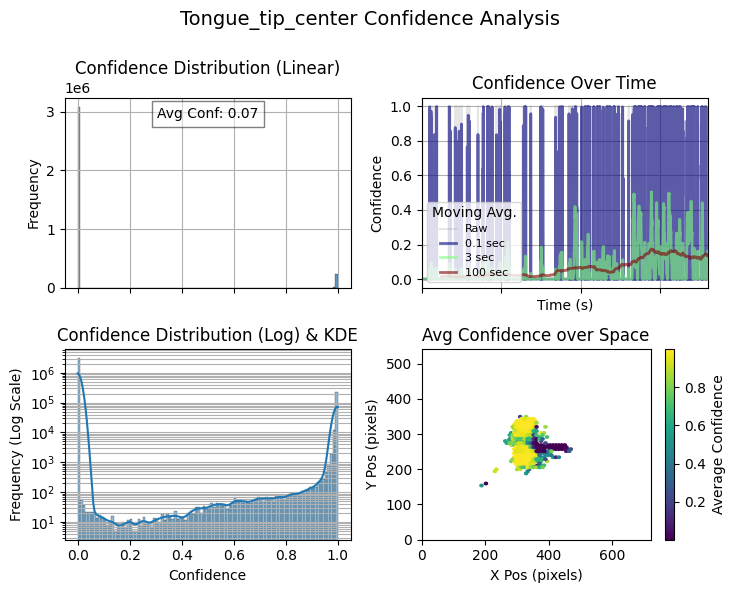

In [9]:
#test single session on batch analysis

save_root = "/root/capsule/scratch/session_analysis_in_distribution" #update save location as needed
data_root = Path("/root/capsule/data")

pred_csv_list = [
        "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-23_14-19-57/bottom_camera.csv"
]

run_batch_analysis(pred_csv_list, data_root, save_root)

In [ ]:
# # look into individual session for errors when generating dfs


# data_root = Path("/root/capsule/data")

# pred_csv = "/root/capsule/data/behavior_751766_2025-02-11_11-53-32_videoprocessed_2025-07-17/pred_outputs/video_preds/bottom_camera_predictions.csv"
# session_id = get_session_name_from_path(str(pred_csv))

# # ---- 1) Generate DFs ----
# nwb, tongue_kins, tongue_movs, kps_raw, tongue_trials = generate_tongue_dfs(pred_csv, data_root)

In [ ]:
# # testing plotting function

# # Select a trial (first row as example)
# trial_row = nwb.df_trials.iloc[25]

# # Set output path for the plot
# save_path = "example_trial_kinematics.png"

# # Call the plotting function
# plot_kinematic_vs_time(
#     tongue_kins=tongue_kins,
#     trial_row=trial_row,
#     time_col="time_in_session",         # or "session_time" if that's your column
#     value_cols=["x", "y"],              # or any kinematic columns you want to plot
#     save_path=save_path,
#     licks_df=nwb.df_licks,              # pass the licks DataFrame
#     covered_col="nearest_movement_id"   # column indicating coverage
# )

# print(f"Plot saved to {save_path}")

In [ ]:
# #adding videos later

# analysis_root = "/root/capsule/scratch/session_analysis_in_distribution"
# data_root = "/root/capsule/data"

# for session_id in os.listdir(analysis_root):
#     session_path = os.path.join(analysis_root, session_id)
#     inter_dir = os.path.join(session_path, "intermediate_data")
#     # Check if intermediate data exists and has required files
#     required_files = [
#         "tongue_movs.parquet",
#         "tongue_kins.parquet",
#         "nwb_df_licks.parquet",
#         "nwb_df_trials.parquet"
#     ]
#     if not os.path.isdir(inter_dir) or not all(os.path.isfile(os.path.join(inter_dir, f)) for f in required_files):
#         print(f"Skipping {session_id}: missing intermediate data.")
#         continue
#     try:
#         extract_example_clips_for_session(session_id, analysis_root, data_root)
#     except Exception as e:
#         print(f"Error processing {session_id}: {e}")